##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

pip install torch torchvision

In [68]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [69]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [70]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [71]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [72]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [73]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and training_target_cols variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [74]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [75]:
# X: The geographic latitude column pointing where the crime occurred.
# Y: The geographic longitude column pointing the location of the criminal activity.
# Area_Command: The column denotes the specific police division handling the crime incident.
# NIBRSOffenseCode: A unique code that helps in categorizing the type of crime happened.
# DayOfWeek: This helps in representing which day of the week the occurred crime is reported to authorities.
# Time: This Column indicates the hour during the day when the crime incident was reported.
# VictimCount: This Column Indicates total number of individuals affected by the crime.

### Input Variables:
    # X 
    # Y 
    # ReportedOn 
    # Area_Command
    # NIBRSOffenseCode
    
### training_target_cols Variable:
    #VictimCount

In [76]:
Ranges = df.describe().loc[['min', 'max']]
print(Ranges.transpose())

                         min        max
X                -116.000000 -114.62557
Y                  35.068419   37.00000
Area_Command        0.000000   11.00000
NIBRSOffenseCode    0.000000    2.00000
DayOfWeek           0.000000    6.00000
Time                0.000000   23.00000
VictimCount         0.000000    6.00000


## Data Scaling, Shifting, or Normalization:

**Longitude (X) & Latitude (Y):** 
    The latitude and longitude values are maintaining within a given range, This clearly shows that normalization may not be a mandatory thing. However, when Using neural networks, scaling them can enhance model performance in a far better way and results will be better.
    
**ReportedOn:** 
    This column encapsulates two potential training_feature_columns which are the hour and day of the week. Post extraction, normalizing the hour can be beneficial. On the other hand, the day will be better represented using one-hot encoding.
    
**VictimCount(training_target_cols Variable):** 
    For certain models, especially neural networks, normalizing the training_target_cols variable can lead to improved convergence and performance and leads to better results.
    
**Area_Command & NIBRSOffenseCode:** 
    Given their categorical nature of data, one-hot encoding is the ideal preprocessing step for these columns.
    
**Remaining columns:** 
    Neural network-based models are sensitive to input scales. So, if we are using them, it is suggested to consider normalization or scaling for all relevant columns to ensure better performance.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [78]:
from torch.utils.data import DataLoader, random_split, Subset
feature_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
from torch.utils.data import TensorDataset
training_feature_columns = df[feature_columns]
training_target_cols = df['VictimCount']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_feature_columns.values, training_target_cols.values, test_size=0.25, random_state=42)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Size of training data:", len(train_dataset))
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break


Size of training data: 206
Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper computed_loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

#### 1. Loss Function:
- When predicting continuous values in regression tasks, the Mean Squared Error (MSE) is often the go-to loss function. This aligns with the use of nn.MSELoss() in code.

#### 2. Size of Predicted Output:
- For regression task, each prediction should represent the number of crime victims, resulting in a single continuous output value i.e., 1.

#### 3. Choice of Architecture:
- Neural network is designed with multiple layers to capture complex patterns within the data. 
- The first layer uses the ReLU activation function, known for its efficiency.
- while the subsequent layers use tanh to introduce non-linearity and improve prediction.

#### 4. Optimizer and Learning Rate:
- We have opted for the Adadelta optimizer, which adjusts the learning rate based on past gradients.
- This often yields stable and efficient training.
- Although the initial learning rate is set to 0.001.
- This value can be changed if required for performance enhancement.


#### 5. Training Loop and Epochs:
- The model is trained over multiple epochs where each epoch processes the entire dataset.
- Within each epoch, data is feeded in batches to streamline and speed up the training process.

#### 6. Model Evaluation:
- For the model performance, the Mean Squared Error(MSE) is computed on test dataset at the close of each epoch. 
- This gives understandable insights about how better our model for unobserved data.



In [79]:
# Training and Evaluation Functions
def train_for_one_epoch(neural_net, training_loader, weight_optimizer, loss_function):
    neural_net.train()
    cumulative_loss = 0.0
    
    for input_data, true_labels in training_loader:
        predicted_labels = neural_net(input_data)
        true_labels_reshaped = true_labels.view(-1)
        current_loss = loss_function(predicted_labels.flatten(), true_labels_reshaped)
        weight_optimizer.zero_grad()
        current_loss.backward()
        weight_optimizer.step()
        cumulative_loss += current_loss.item()
        
    return cumulative_loss / len(training_loader)

In [93]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Dataset Preparation
batch_size = 64
Data_Trained = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
Data_Tested = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
trained_data_loader = DataLoader(Data_Trained, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Data_Tested, batch_size=batch_size, shuffle=False)

# Model Definition
class Regression(nn.Module):
    def __init__(self, input_size):
        super(Regression, self).__init__()        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        
        x = self.fc4(self.dropout(self.leaky_relu(self.fc3(self.dropout(self.leaky_relu(self.fc2(self.dropout(self.leaky_relu(self.fc1(x))))))))))
        return x

# Model, Loss, and Optimizer
input_size = 6
model = Regression(input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)



def assess_neural_net(neural_net, evaluation_loader, loss_function):
    neural_net.eval()
    cumulative_loss = 0.0
    
    with torch.no_grad():
        for input_data, true_labels in evaluation_loader:
            predicted_output = neural_net(input_data)
            cumulative_loss += loss_function(predicted_output.flatten(), true_labels.flatten()).item()
            
    return cumulative_loss / len(evaluation_loader)

# Training Loop
num_epochs = 500
epochs = 500
for current_epoch in range(num_epochs):
    average_train_loss = train_for_one_epoch(model, trained_data_loader, optimizer, loss_function)
    average_test_loss = assess_neural_net(model, test_loader, loss_function)
    print(f'Epoch [{current_epoch + 1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Testing Loss: {average_test_loss:.4f}')


Epoch [1/500], Training Loss: 47.0189, Testing Loss: 31.3561
Epoch [2/500], Training Loss: 44.8985, Testing Loss: 31.0056
Epoch [3/500], Training Loss: 45.2952, Testing Loss: 30.6584
Epoch [4/500], Training Loss: 44.5122, Testing Loss: 30.2989
Epoch [5/500], Training Loss: 50.3303, Testing Loss: 29.9554
Epoch [6/500], Training Loss: 46.6529, Testing Loss: 29.6026
Epoch [7/500], Training Loss: 35.6923, Testing Loss: 29.2980
Epoch [8/500], Training Loss: 39.9978, Testing Loss: 28.9560
Epoch [9/500], Training Loss: 41.8794, Testing Loss: 28.6110
Epoch [10/500], Training Loss: 36.4021, Testing Loss: 28.3066
Epoch [11/500], Training Loss: 36.4088, Testing Loss: 27.9909
Epoch [12/500], Training Loss: 42.9712, Testing Loss: 27.6567
Epoch [13/500], Training Loss: 36.7040, Testing Loss: 27.3482
Epoch [14/500], Training Loss: 39.1036, Testing Loss: 27.0292
Epoch [15/500], Training Loss: 42.1275, Testing Loss: 26.6974
Epoch [16/500], Training Loss: 42.4219, Testing Loss: 26.3551
Epoch [17/500], T

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the computed_loss function different?
* Calculate the Accuracy for test data as the number of corrected_data classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [94]:
# How would you find the number of classes on the output data?
num_of_classes_unique = df['VictimCount'].nunique()
print(num_of_classes_unique)

7


#### 2. How is the architecture different?
- For the final output layer, the neuron count matches the number of unique classes.
- In multi-class classification scenarios, the softmax activation is often utilized in the final or concluding layer.

#### 3. How is the computed_loss function different?
- The approach for classification tasks is to utilize the Cross-Entropy Loss. 
- In PyTorch, it is achieved using nn.CrossEntropyLoss().
- It is important to note that PyTorch implementation seamlessly merges softmax activation with the cross-entropy computation by eliminating the need for a standalone softmax activation in the model.

In [95]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class CrimeClassifier(nn.Module):
    def __init__(self, input_training_feature_columns, neurons_hidden, num_classes):
        super(CrimeClassifier, self).__init__()
        self.layer1 = nn.Linear(input_training_feature_columns, neurons_hidden)
        self.layer2 = nn.Linear(neurons_hidden, num_classes)
    
    def forward(self, data):
        data = torch.relu(self.layer1(data))
        return self.layer2(data)

def prepare_data_loaders(data_train, labels_train, data_test, labels_test, batch_sz):
    train_set = TensorDataset(torch.Tensor(data_train), torch.LongTensor(labels_train))
    test_set = TensorDataset(torch.Tensor(data_test), torch.LongTensor(labels_test))
    
    loader_train = DataLoader(train_set, batch_size=batch_sz, shuffle=True)
    loader_test = DataLoader(test_set, batch_size=batch_sz, shuffle=False)
    
    return loader_train, loader_test

# Prepare DataLoader
batch_size = 64
trained_data_loader, test_loader = prepare_data_loaders(X_train, y_train, X_test, y_test, batch_size)

# Initialize model, loss, and optimizer
input_training_feature_columns = X_train.shape[1]
hidden_neurons = 128
num_classes = df['VictimCount'].nunique()

model = CrimeClassifier(input_training_feature_columns, hidden_neurons, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [96]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train_one_epoch(self, trained_data_loader):
        self.model.train()
        cumulative_loss = 0.0

        for inputs, targets in trained_data_loader:
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            cumulative_loss += loss.item()

        return cumulative_loss / len(trained_data_loader)

    def evaluate(self, test_loader):
        self.model.eval()
        cumulative_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == targets).sum().item()
                total_samples += targets.size(0)
                cumulative_loss += self.criterion(outputs, targets).item()

        accuracy = 100.0 * correct_predictions / total_samples
        avg_loss = cumulative_loss / len(test_loader)

        return avg_loss, accuracy
    epochs =  1000
    def train(self, trained_data_loader, test_loader, epochs):
        for epoch in range(epochs):
            train_loss = self.train_one_epoch(trained_data_loader)
            test_loss, accuracy = self.evaluate(test_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Train data Loss: {train_loss:.4f}, Test data Loss: {test_loss:.4f}, Test Model Accuracy: {accuracy:.2f}%')

trainer = Trainer(model, optimizer, criterion)
trainer.train(trained_data_loader, test_loader, epoch_count)


Epoch [1/500], Train data Loss: 9.9229, Test data Loss: 5.9362, Test Model Accuracy: 46.38%
Epoch [2/500], Train data Loss: 3.2180, Test data Loss: 1.8126, Test Model Accuracy: 42.03%
Epoch [3/500], Train data Loss: 2.5921, Test data Loss: 1.7448, Test Model Accuracy: 39.13%
Epoch [4/500], Train data Loss: 2.4777, Test data Loss: 2.1980, Test Model Accuracy: 46.38%
Epoch [5/500], Train data Loss: 2.1564, Test data Loss: 2.6979, Test Model Accuracy: 46.38%
Epoch [6/500], Train data Loss: 1.8088, Test data Loss: 1.5121, Test Model Accuracy: 40.58%
Epoch [7/500], Train data Loss: 2.1065, Test data Loss: 1.4510, Test Model Accuracy: 40.58%
Epoch [8/500], Train data Loss: 1.6255, Test data Loss: 2.0518, Test Model Accuracy: 46.38%
Epoch [9/500], Train data Loss: 1.7637, Test data Loss: 1.5457, Test Model Accuracy: 46.38%
Epoch [10/500], Train data Loss: 1.4144, Test data Loss: 1.1778, Test Model Accuracy: 43.48%
Epoch [11/500], Train data Loss: 1.6150, Test data Loss: 1.3424, Test Model Acc

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the corrected_data class label.

### **Reflection on Tasks 3 and 4:**

While doing Tasks 3 and 4, we dived deep into neural network modeling to address two distinct challenges: 
- Finding the count of crime victims as a continuous value. 
- To Categorize the number of victims into specific groups.

**Task 3 (Regression):**
- Three hidden layers makes the highly advanced model that we selected.
- To control overfitting, we added dropout and LeakyReLU activations.
- Our loss function measure was the Mean Squared Error (MSE), a common option for regression issues.The Adadelta optimizer was employed, and its learning rate was set at 0.001.
- Using the test set mean square error, we evaluated the model's effectiveness after training.

**Task 4 (Classification):**
- Enhanced with ReLU activation, this model had a single hidden layer and was more simplified.
- Since classification was our goal, we chose the Cross-Entropy loss function.
- The Adam optimizer, which has become known for its effectiveness, was utilized to train the model.
- We used the test set's accuracy as a direct indicator of the model's precision in order to assess it.

**Comparison:**
- Task 3 model was undeniably more complex, possibly to capture intricate patterns in the continuous data.
- Task 4 while simpler, demanded additional steps to manage categorical targets.
- The accuracy metric gave a direct understanding of the model's performance.
  
**Which was best and Why?**
- The decision changes based on the specific problem.
- For precise predictions of crime victim numbers, Task 3's approach is best chosen.
- However, for classifying counts into distinct categories Task 4 is the best solution to go with.
- Our observations suggest that the classification model from Task 4 shows better accuracy. Nonetheless, the choice of metric should be aligned with the end-goal what we need to achieve.

To summarize, both task 3 and 4  both are good in their own way as per the outcome expected or the problem given. However, they did not perform better in terms of the model architecture, loss function metric, and evaluation methods for the task specific requirements.

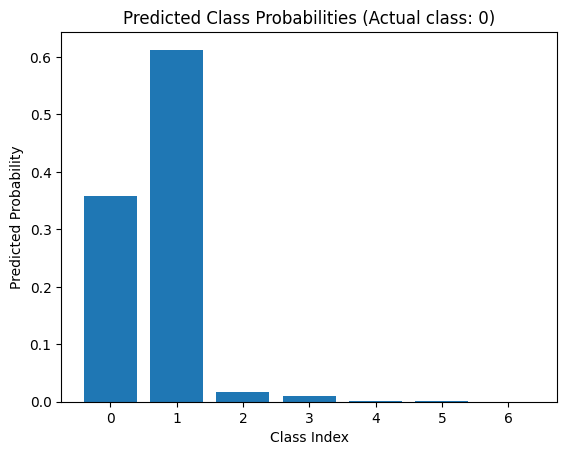

In [97]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def fetch_incorrect_prediction(neural_net, evaluation_loader):
    """Retrieve an incorrectly predicted sample from the evaluation dataset."""
    neural_net.eval()
    with torch.no_grad():
        for features, true_labels in evaluation_loader:
            neural_net_predictions = neural_net(features)
            _, estimated_classes = torch.max(neural_net_predictions, 1)
            # Identify the first incorrect prediction in the batch
            incorrect_indices = (estimated_classes != true_labels).nonzero(as_tuple=True)[0]
            if len(incorrect_indices) > 0:
                idx = incorrect_indices[0]
                return features[idx], neural_net_predictions[idx], true_labels[idx]
    
    return None, None, None

def display_predicted_probabilities(softmax_values, actual_class):
    """Visualize the softmax probabilities for the specified sample."""
    class_indices = list(range(len(softmax_values)))
    plt.bar(class_indices, softmax_values)
    plt.xlabel('Class Index')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Class Probabilities (Actual class: {actual_class})')
    plt.xticks(class_indices)
    plt.show()

# Extract an incorrectly predicted sample
sample_feature, prediction_output, actual_class_label = fetch_incorrect_prediction(model, test_loader)

if sample_feature is not None:
    # Convert neural network outputs to softmax probabilities
    predicted_probs = F.softmax(prediction_output, dim=0).cpu().numpy()
    display_predicted_probabilities(predicted_probs, actual_class_label.item())
else:
    print("No incorrect predictions found in the provided samples!")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


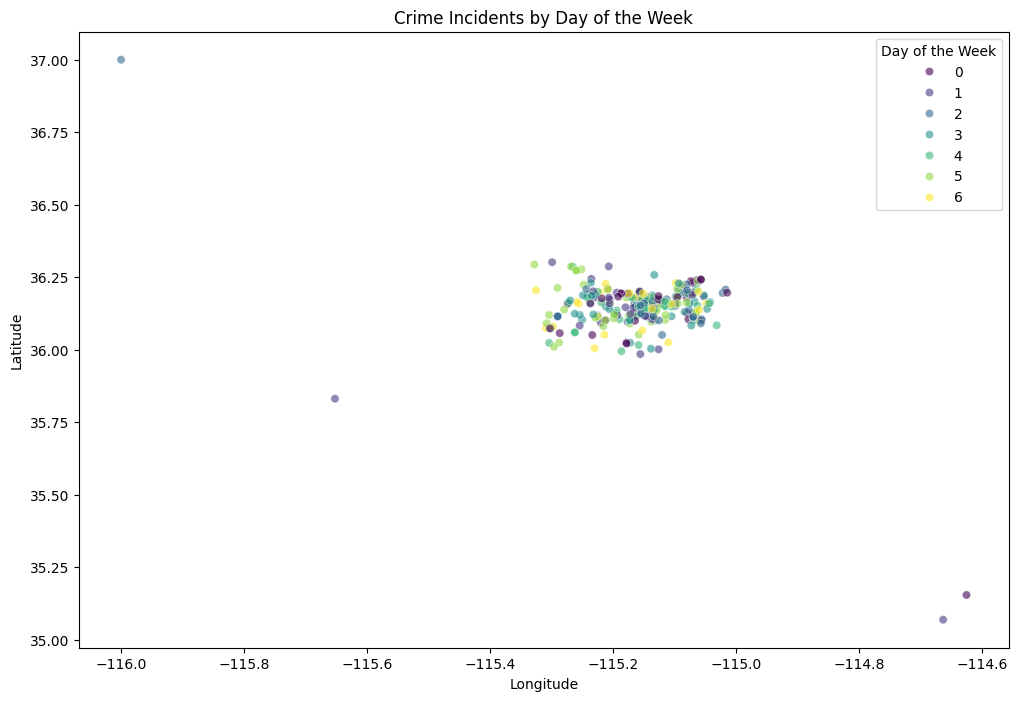

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Scatter plot colored by DayOfWeek
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette='viridis', alpha=0.6)
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of the Week')
plt.show()


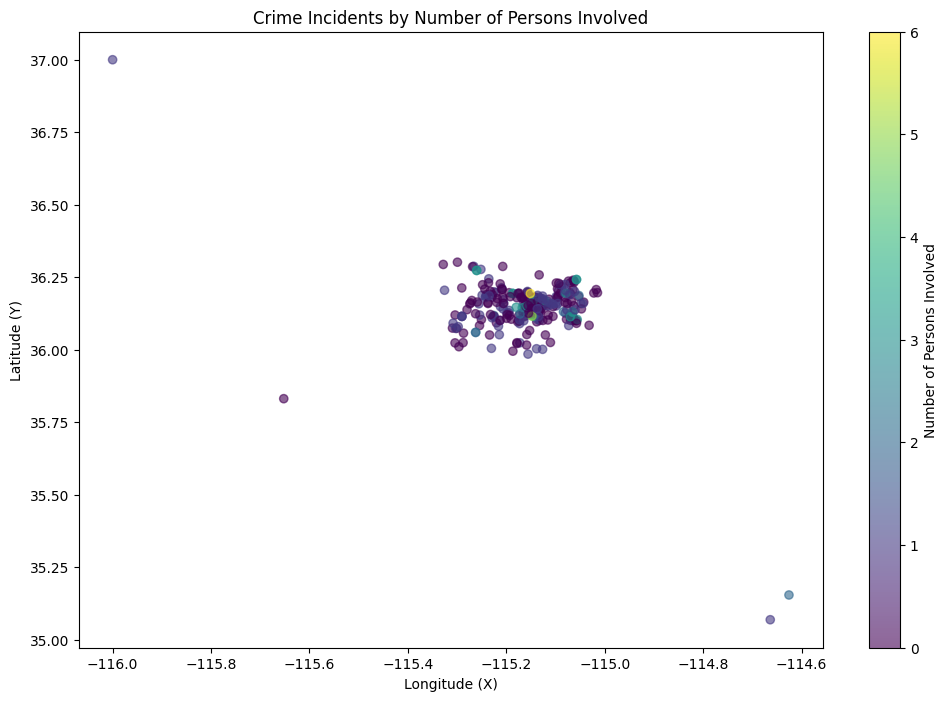

In [99]:
plt.figure(figsize=(12, 8))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Persons Involved')
plt.show()

In [100]:
# Task 6.3: Counting and sorting crimes by day of week
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()
crime_counts_by_day

DayOfWeek
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: count, dtype: int64